In [2]:
# TODO: Merge these imports into the cells where they are used. 
# %pip install scikit-learn
# %pip install numpy
# %pip install pandas
# %pip install pyaqsapi
# %pip install certifi
# %pip install requests
import os
# from glob import glob
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# import typing as t
# import pyaqsapi as aqs
# from datetime import date
# from functools import reduce

In [ ]:
beaco2n_df = pd.read_csv("./BEACO2N_measurements/myron.csv")
aqs_df = pd.read_csv("./reference_measurements/aqs_myron.csv")


def clean_BEACO2N(df: pd.DataFrame) -> pd.DataFrame :
    # Store time in Pandas datetime format.
    df.rename(columns={"datetime":"timestamp", "co2_raw":"co2"}, inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.round("h")

    # Drop redundant time columns
    df.drop(columns=["local_timestamp", "epoch", "node_file_id", "node_id"], inplace=True)
    
    # For all columns suffixed by "_wrk_aux", convert from Volts to milliVolts (*1000) and remove suffix
    wrk_aux_cols = df.filter(regex=r"_wrk_aux$").columns
    df[wrk_aux_cols] *= 1000
    df.rename(columns= {col : col.replace("_wrk_aux", "") for col in wrk_aux_cols}, inplace=True)

    # Use only corrected BEACO2N data
    df.drop(columns='co', inplace=True)
    df.rename({'co_corrected':'co'}, inplace=True)
    
    # Drop all datapoints with incomplete data (e.g. missing co measurement)
    df.dropna(inplace=True)
    df.set_index("timestamp")
    return df

def clean_aqs(df: pd.DataFrame) -> pd.DataFrame :
    df.rename(columns={"sample_measurement" : "co"}, inplace=True)
    df["timestamp"] = df["date_gmt"] + ' ' + df["time_gmt"]
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True) # should already be hourly, don't need to round.
    df.drop(columns=[col for col in df.columns if col not in ["co", "timestamp"]], inplace=True)
    df = df[["timestamp", "co"]]

    df.dropna(inplace=True)
    df.set_index("timestamp")
    return df

beaco2n_df = clean_BEACO2N(beaco2n_df)
beaco2n_df.drop(columns=[col for col in beaco2n_df.columns if col not in ["timestamp", "co", "temp", "rh"]], inplace=True)
aqs_df = clean_aqs(aqs_df)
merged_df = pd.merge(beaco2n_df, aqs_df, how='inner', on='timestamp', suffixes=["_meas", "_aqs"]).set_index("timestamp")

NOTE: I am assuming the conversion between BEACO2N output and RIDEM output is a coefficient. If the terms are non-linear then this method will not work accurately. 

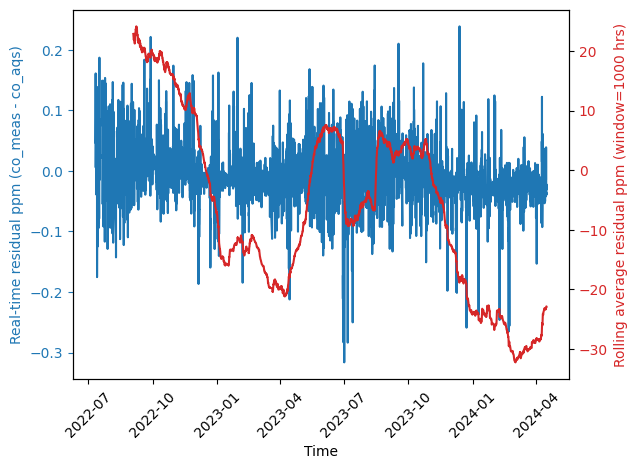

In [37]:
window = 1000

fig, ax1 = plt.subplots()

ax1.plot(merged_df['co_meas'] - merged_df['co_aqs'], color='tab:blue')
ax1.tick_params(axis='y', color='tab:blue')
ax1.set_xlabel("Time")
ax1.set_ylabel("Real-time residual ppm (co_meas - co_aqs)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(pd.Series(merged_df['co_meas'] - merged_df['co_aqs']).rolling(window=window).sum(), color='tab:red')
ax2.set_ylabel(f"Rolling average residual ppm (window={window} hrs)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler
model = LinearRegression()

y_train: pd.Series
y_test: pd.Series
X_train: pd.DataFrame
X_test: pd.DataFrame

# merged_df['co_meas'] = MinMaxScaler().fit_transform(merged_df[['co_meas']])

y_train, y_test, X_train, X_test = train_test_split(merged_df['co_aqs'], merged_df[['co_meas','temp','rh']], random_state=0)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index).sort_index()
y_test.sort_index().to_csv('./model_predictions/myron/true/myron_aqs.csv')
y_pred.to_csv('./model_predictions/myron/pred/myron_beaco2n_pred.csv')
X_test['co_meas'].to_csv("./model_predictions/myron/raw/myron_beaco2n_raw.csv")